<bound method NDFrame.head of      Unnamed: 0                                             SMILES  Type
0             1                     NC1=C(Cl)C(Cl)=NC(C(O)=O)=C1Cl     0
1            12                  CCCCOCCOCCOCC1=CC2=C(OCO2)C=C1CCC     0
2            73                CC(C)(C1=CC=C(O)C=C1)C1=CC=C(O)C=C1     1
3           154              ClC(Cl)C(Cl)(Cl)SN1C(=O)C2CC=CCC2C1=O     0
4           271  [Mn++].[Zn++].[S-]C(=S)NCCNC([S-])=S.[S-]C(=S)...     0
5           318                                             OB(O)O     0
6           343                              CCNC1=NC(N)=NC(Cl)=N1     0
7           347  COC(=O)C1=C(N(C)N=C1Cl)S(=O)(=O)NC(=O)NC1=NC(O...     0
8           364                  ClC1=CC=CC=C1NC1=NC(Cl)=NC(Cl)=N1     0
9           366                         CC(OC1=CC(Cl)=CC=C1)C(O)=O     0
10          372  COC(=O)C1=CC=CC=C1S(=O)(=O)NC(=O)N(C)C1=NC(OC)...     0
11          374                        CC(C)OC(=O)NC1=CC=CC(Cl)=C1     0
12          455      

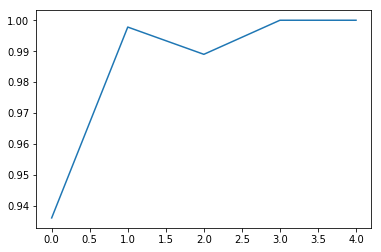

In [15]:
# %matplotlib inline #notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것 

import numpy
import pandas
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem, DataStructs
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

#setting the seed for reproducibility
#seed = 10110
seed = 12061204
numpy.random.seed(seed)

#폴더의 파일목록 불러오기
import os
path_dir = 'C:\/test/AOP-ToxCast-Deep-Learning/Deepchem toxcast_data all/Seperated'
file_list = os.listdir(path_dir)
input_files = []
i = 0

for item in file_list :
        input_files.append(item)
        #print(item)
        
dataframe2 = pandas.read_csv('note.csv')
        
def create_deep_learning_model():
    model = Sequential()
    #첫번째 인자 : 출력 뉴런의 수 , input_dim : 입력 뉴런의 수, activation : 활성화 함수.
    model.add(Dense(2048, input_dim=2048, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model    

def main(input_name):
    dataframe = pandas.read_csv('C:\/test/Deepchem toxcast_data all/Seperated/'+input_name)
    print(dataframe.head)
    mols = []
    fps = []
    i = 0 #전체 물질 개수
    j = 0 #type 이 1인 물질 개수 즉 ligand개수
    
    for index, row in dataframe.iterrows():
        mol = Chem.MolFromSmiles(row['SMILES'])
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
        mols.append(mol)
        fps.append(fp)
        i += 1
        if(row["Type"]==1) : 
            j += 1
    
    np_fps = []
    for fp in fps:
        arr = numpy.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        np_fps.append(arr)
        
    np_fps_array = numpy.array(np_fps)
    
#     my_string = input_name
#     Type = my_string.split('(')[0]
    enc_y = dataframe['Type']
    
    sm = SMOTE(random_state=12, ratio = 'minority')
    x_train_res, y_train_res = sm.fit_sample(np_fps_array, enc_y) #결과데이터

    # evaluate model with standardized dataset
    #estimator = KerasClassifier(build_fn=create_deep_learning_model, nb_epoch=100, batch_size=5, verbose=0)
    estimator = KerasClassifier(build_fn=create_deep_learning_model, nb_epoch=100, batch_size=5)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    #results = cross_val_score(estimator, np_fps_array, enc_y, cv=kfold)
    results = cross_val_score(estimator, x_train_res, y_train_res, cv=kfold)
    #https://datascienceschool.net/view-notebook/266d699d748847b3a3aa7b9805b846ae/
    print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

    y_pred = cross_val_predict(estimator, x_train_res, y_train_res, cv=kfold)
    conf_mat = confusion_matrix(y_train_res, y_pred)
    conf_mat


    model = create_deep_learning_model()
    history = model.fit(x_train_res, y_train_res, epochs=5, batch_size=5) #histroy 객체를 만환한다 이것을 이용해서  각 단계에서의 acc와 loss값을 알 수 있다
    plt.plot(history.history['acc'])
    print(history.history['acc'])
    plt.show()
    
    model.save("C:\/test/AOP-ToxCast-Deep-Learning/trained_models/models_2/"+input_name+'_model' + '(' + repr(history.history['acc'][-1]) + ')'+'.h5')
    
    #모델정보 정리를 위한 코드.
    Total_Chemicals = i
    Ligand = j
    Non_ligand = i - j
    Model_accuacy = repr(history.history['acc'][-1])
    info_list = [Total_Chemicals, Ligand, Non_ligand, Model_accuacy ]
    dataframe2[input_name.replace("(input).csv","")] = info_list
    

if __name__ == "__main__":
#     for input_name in input_files :
        main('APR_Hepat_Steatosis_24hr_up(input)2.csv')    #d우선 모델 빨리 만들어보려고 이걸로.
        dataframe2.to_csv("note2.csv", mode='w')

In [ ]:
# https://tykimos.github.io/2017/09/24/Custom_Metric/ 
# https://keras.io/callbacks/
# https://keras.io/visualization/#training-history-visualization